In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tokenizer import Tokenizer

# Tokenizer & Input Embedding

In [2]:
tokenizer = Tokenizer('./data/sp/src_sp.model', './data/sp/tgt_sp.model')

src_sentence = "I am a student and I love programming."
tgt_sentence = "我是一个学生，我爱编程"

src_tokens = tokenizer.encode_src(src_sentence, False, False)
tgt_tokens = tokenizer.encode_tgt(tgt_sentence, False, False)


src_tokens, tgt_tokens


([129, 2020, 12, 4983, 10, 129, 3881, 601, 2864, 6],
 [645, 468, 1385, 4, 134, 1603, 4921, 3022])

In [3]:
tokenizer.tokenize_src(src_sentence), tokenizer.tokenize_tgt(tgt_sentence)

(['▁I',
  '▁am',
  '▁a',
  '▁student',
  '▁and',
  '▁I',
  '▁love',
  '▁program',
  'ming',
  '.'],
 ['▁我', '是一个', '学生', ',', '我', '爱', '编', '程'])

In [4]:
src_input_embedding = nn.Embedding(16000, 8)(torch.tensor(src_tokens))
tgt_input_embedding = nn.Embedding(16000, 8)(torch.tensor(tgt_tokens))

src_input_embedding.shape, tgt_input_embedding.shape

(torch.Size([10, 8]), torch.Size([8, 8]))

# Postional Embedding

In [5]:
class PositionalEncoder(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.dim = config.dim
        # Make initial positional encoding matrix with 0
        pe_matrix= torch.zeros(config.max_seq_len, config.dim) # (L, d_model)

        # Calculating position encoding values
        for pos in range(config.max_seq_len):
            for i in range(config.dim):
                if i % 2 == 0:
                    pe_matrix[pos, i] = math.sin(pos / (10000 ** (2 * i / config.dim)))
                elif i % 2 == 1:
                    pe_matrix[pos, i] = math.cos(pos / (10000 ** (2 * i / config.dim)))

        pe_matrix = pe_matrix.unsqueeze(0) # (1, L, d_model)
        self.positional_encoding = pe_matrix.to(device=device).requires_grad_(False)

    def forward(self, x):
        x = x * math.sqrt(self.dim) # (B, L, d_model)
        x = x + self.positional_encoding # (B, L, d_model)

        return x


# Attention

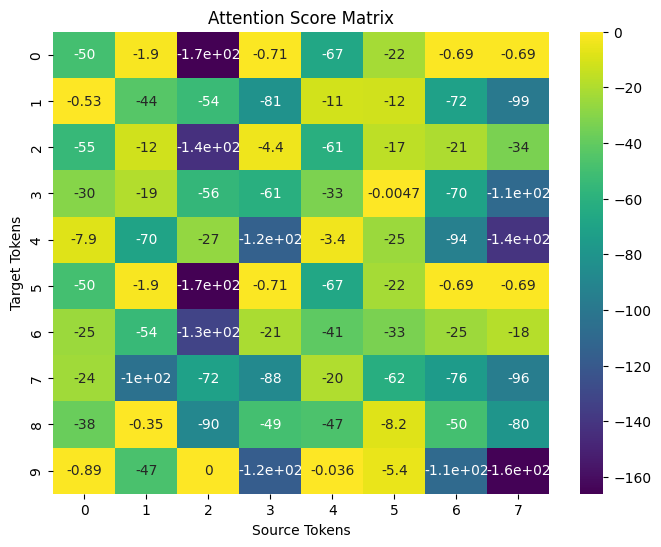

In [6]:
torch.manual_seed(7118846886692823945)

src_input_embedding = nn.Embedding(16000, 8)(torch.tensor(src_tokens))
tgt_input_embedding = nn.Embedding(16000, 8)(torch.tensor(tgt_tokens))

wq = torch.randn(8, 8)
wk = torch.randn(8, 8)

softmax = nn.LogSoftmax(dim=-1)

src_k = src_input_embedding @ wk
tgt_q = tgt_input_embedding @ wq

attention_score = softmax(tgt_q @ src_k.T).T

plt.figure(figsize=(8, 6))
sns.heatmap(attention_score.detach().numpy(), annot=True, cmap='viridis')
plt.title('Attention Score Matrix')
plt.xlabel('Source Tokens')
plt.ylabel('Target Tokens')
plt.show()